In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lower, regexp_replace, sum, struct
from pyspark.sql.types import StringType,  IntegerType
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
spark = SparkSession.builder \
    .appName("Sentiment") \
    .getOrCreate()

df = spark.read.csv("data5.csv", header=True, inferSchema=True)
print("Original Data:")
df.show(truncate=20)
print(df.count())

unique_rates = df.select("Rate").distinct().collect()
unique_rates_list = [row.Rate for row in unique_rates]
print(unique_rates_list)

Original Data:
+--------------------+-----+----+-----------------+--------------------+
|        Product_name|Price|Rate|           Review|             Summary|
+--------------------+-----+----+-----------------+--------------------+
|boAt Blitz 1500 M...| 3499|   1|Absolute rubbish!|This product is g...|
|boAt Blitz 1500 M...| 3499|   1| Terrible product|Worst quality i e...|
|boAt Blitz 1500 M...| 3499|   5|        Wonderful| Super se upper ????|
|boAt Blitz 1500 M...| 3499|   5|        Excellent|Product quality i...|
|boAt Blitz 1500 M...| 3499|   5|        Just wow!|This is very good...|
|boAt Blitz 1500 M...| 3499|   4|  Value-for-money|Value for money a...|
|boAt Blitz 1500 M...| 3499|   5|          Awesome|          Good sound|
|boAt Blitz 1500 M...| 3499|   5|        Just wow!|           Very nice|
|boAt Blitz 1500 M...| 3499|   5|Worth every penny|Good Value For mo...|
|boAt Blitz 1500 M...| 3499|   5|   Classy product|                Good|
|boAt Blitz 1500 M...| 3499|   5|   

In [ ]:
df=df.na.drop()
print(df.count())
nulls=df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
nulls.show()
for column in ['Review','Summary']:
  df = df.withColumn(column, lower(col(column)))
  df = df.withColumn(column, regexp_replace(col(column), "[^a-zA-Z0-9. ]", ""))
df = df.withColumn('Product_name', regexp_replace(col('Product_name'), "[^a-zA-Z0-9. ]", ""))

clean_df = df.withColumn("Rate", regexp_replace(col("Rate"), "[^0-9]", ""))
clean_df = clean_df.withColumn("Rate", col("Rate").cast("int"))
df = clean_df.filter(col("Rate").isin(1, 2, 3, 4, 5))

unique_rates = df.select("Rate").distinct().collect()
unique_rates_list = [row.Rate for row in unique_rates]
print(unique_rates_list)

print("Cleaned Data:")
df.show(truncate=30)

6199
+------------+-----+----+------+-------+
|Product_name|Price|Rate|Review|Summary|
+------------+-----+----+------+-------+
|           0|    0|   0|     0|      0|
+------------+-----+----+------+-------+

[1, 3, 5, 4, 2]
Cleaned Data:
+------------------------------+-----+----+-----------------+------------------------------+
|                  Product_name|Price|Rate|           Review|                       Summary|
+------------------------------+-----+----+-----------------+------------------------------+
|boAt Blitz 1500 Multimedia ...| 3499|   1| absolute rubbish|this product is good but lo...|
|boAt Blitz 1500 Multimedia ...| 3499|   1| terrible product|worst quality i ever bought...|
|boAt Blitz 1500 Multimedia ...| 3499|   5|        wonderful|               super se upper |
|boAt Blitz 1500 Multimedia ...| 3499|   5|        excellent|product quality is best qua...|
|boAt Blitz 1500 Multimedia ...| 3499|   5|         just wow|this is very good product f...|
|boAt Blitz 150

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.sql.functions import col, sum, isnull, when

for c in df.columns:
  nullcount=df.select(sum(col(c).isNull().cast("int")).alias(c)).collect()[0][0]
  print(nullcount)

0
0
0
0
0


In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.sql.functions import col, sum, isnull, when

In [ ]:
from pyspark.sql.functions import concat_ws
df = df.withColumn("combined", concat_ws(" ", df["Review"], df["Summary"]))

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']

    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"




In [ ]:

sentiment_udf = udf(analyze_sentiment, StringType())
df = df.withColumn("vader_sentiment", sentiment_udf(col("combined")))

df.show(truncate=False)


+-------------------------------------------------------------------------------+-----+----+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|Product_name                                                                   |Price|Rate|Review           |Summary                                                                                                                                                        |combined                                                                                                                                                                        |vader_sentiment|
+-----------------------------------------------------------------------

In [ ]:

tokenizer = Tokenizer(inputCol="combined", outputCol="words")
df_tokenized=tokenizer.transform(df)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_tokenized = remover.transform(df_tokenized)


In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="vader_sentiment", outputCol="sentiment_index")


In [ ]:
index_df=indexer.fit(df_tokenized).transform(df_tokenized)

In [ ]:
hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=1000)
df_hashed = hashingTF.transform(index_df)
df_hashed.show()

+--------------------+-----+----+-----------------+--------------------+--------------------+---------------+--------------------+--------------------+---------------+--------------------+
|        Product_name|Price|Rate|           Review|             Summary|            combined|vader_sentiment|               words|      filtered_words|sentiment_index|            features|
+--------------------+-----+----+-----------------+--------------------+--------------------+---------------+--------------------+--------------------+---------------+--------------------+
|boAt Blitz 1500 M...| 3499|   1| absolute rubbish|this product is g...|absolute rubbish ...|       negative|[absolute, rubbis...|[absolute, rubbis...|            1.0|(1000,[157,166,16...|
|boAt Blitz 1500 M...| 3499|   1| terrible product|worst quality i e...|terrible product ...|       negative|[terrible, produc...|[terrible, produc...|            1.0|(1000,[53,166,209...|
|boAt Blitz 1500 M...| 3499|   5|        wonderful|    

In [ ]:
sentiment_count = df_hashed.groupBy("vader_sentiment").count().orderBy("count", ascending=False)

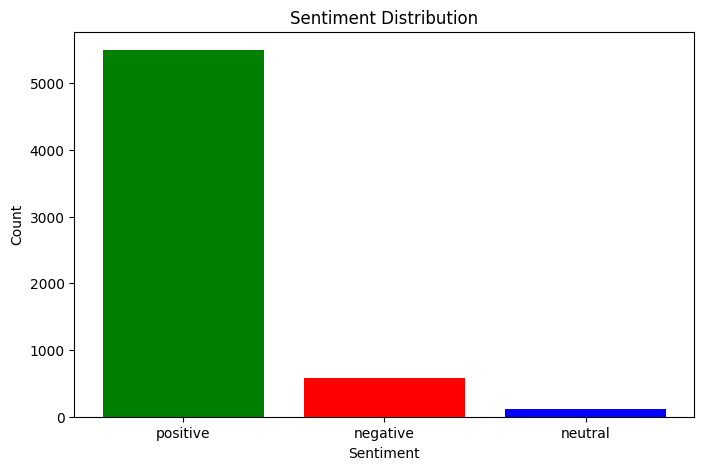

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
sentiment_df = sentiment_count.toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sentiment_df['vader_sentiment'], sentiment_df['count'], color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


<ipython-input-29-5fe56e13f286>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pandas_df, x="Price", y="Rate", palette="coolwarm")


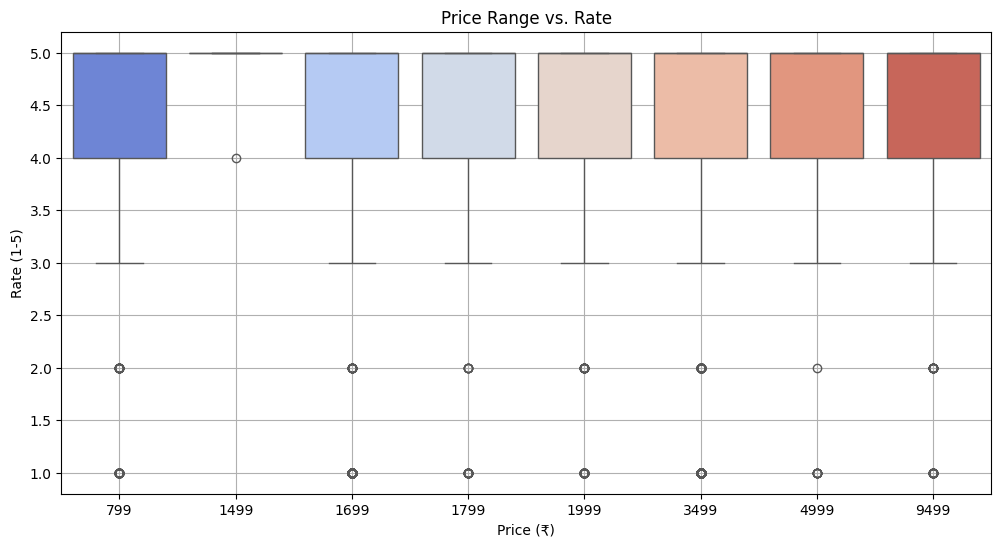

In [ ]:
pandas_df = df_hashed.select("Price", "Rate").toPandas()
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=pandas_df, x="Price", y="Rate", palette="coolwarm")

plt.title("Price Range vs. Rate")
plt.xlabel("Price (₹)")
plt.ylabel("Rate (1-5)")
plt.grid(True)
plt.show()

In [ ]:
fil_df = df_hashed.filter(col("Rate") >= 4)

# Select unique product names
unique_products_df = fil_df.select("Product_name","Price").distinct()
unique_products_pandas = unique_products_df.toPandas()


<ipython-input-33-1da681ac1933>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Price", y="Product_name", data=unique_products_pandas, palette="viridis")


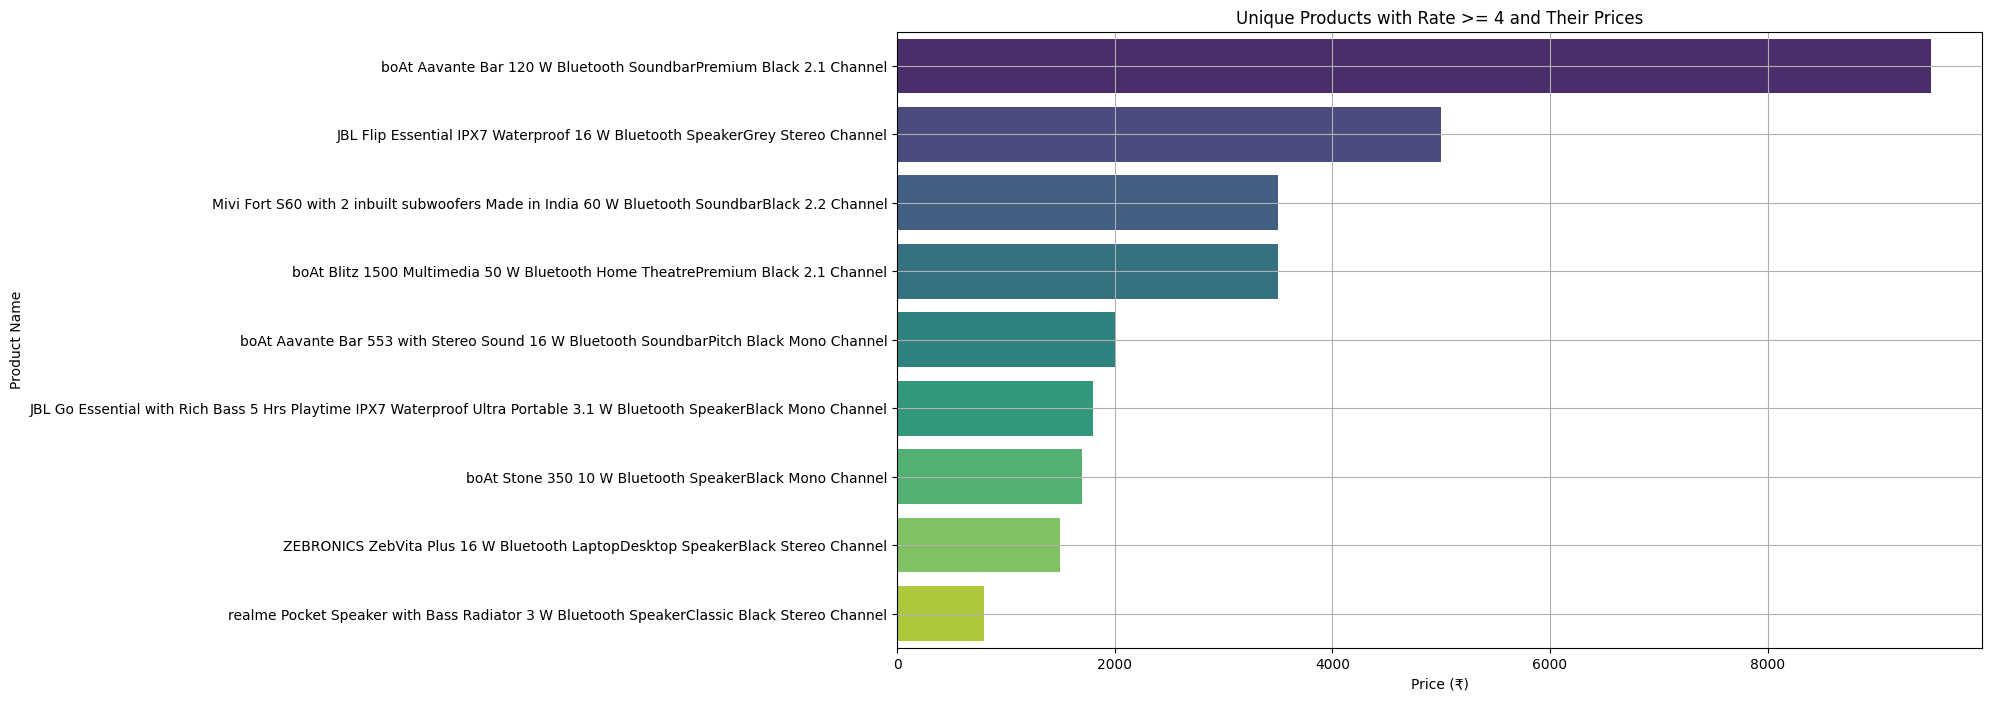

In [ ]:
unique_products_pandas = unique_products_pandas.sort_values("Price", ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x="Price", y="Product_name", data=unique_products_pandas, palette="viridis")

plt.title("Unique Products with Rate >= 4 and Their Prices")
plt.xlabel("Price (₹)")
plt.ylabel("Product Name")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql.functions import col, count

positive_reviews_df = unique_products_df.filter(col('sentiment_index') == 0.0)
positive_counts_df = (
    positive_reviews_df
    .groupBy('Product_name', 'Price')
    .agg(count('*').alias('positive_count'))
)
top_positive_df = positive_counts_df.orderBy(col('positive_count').desc()).limit(5)



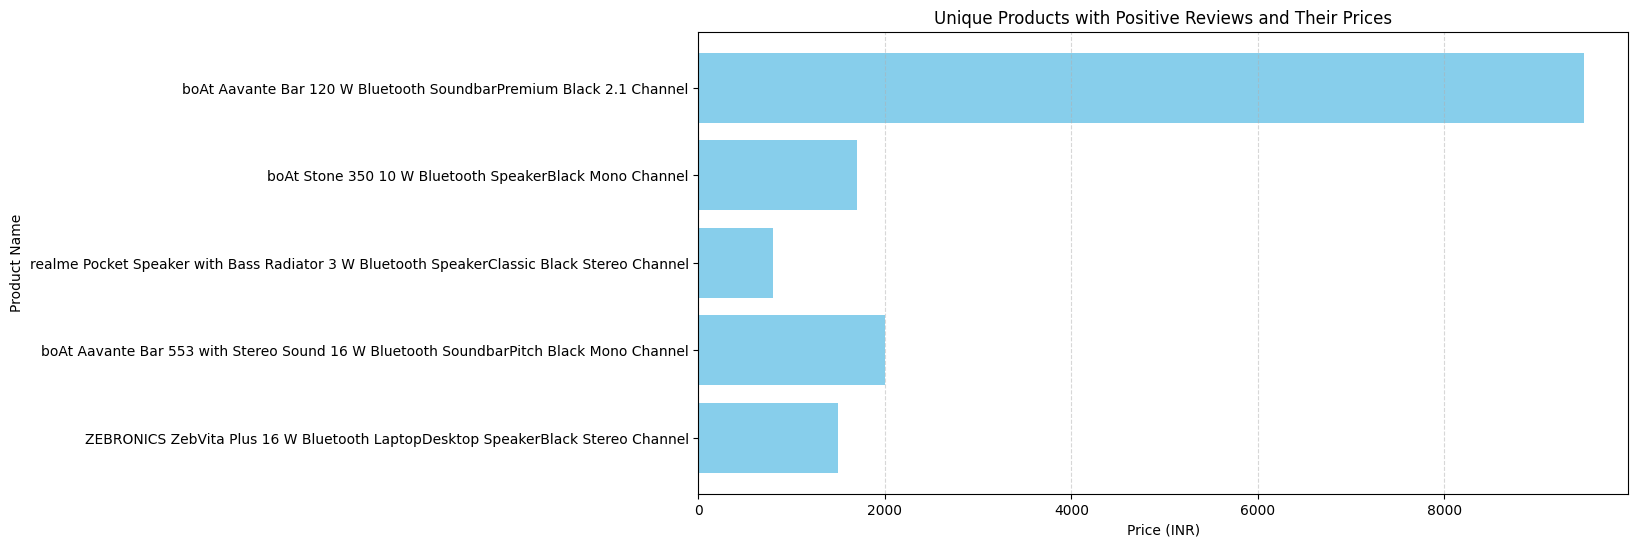

In [ ]:
top_positive_pandas = top_positive_df.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(top_positive_pandas['Product_name'], top_positive_pandas['Price'], color='skyblue')
plt.xlabel('Price (INR)')
plt.ylabel('Product Name')
plt.title('Unique Products with Positive Reviews and Their Prices')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [ ]:

negative_reviews_df = df_hashed.filter(col('sentiment_index') == 1.0)
negative_counts_df = (
    negative_reviews_df
    .groupBy('Product_name', 'Price')
    .agg(count('*').alias('negative_count')))
top_negative_df = negative_counts_df.orderBy(col('negative_count').desc()).limit(5)
top_negative_pandas = top_negative_df.toPandas()

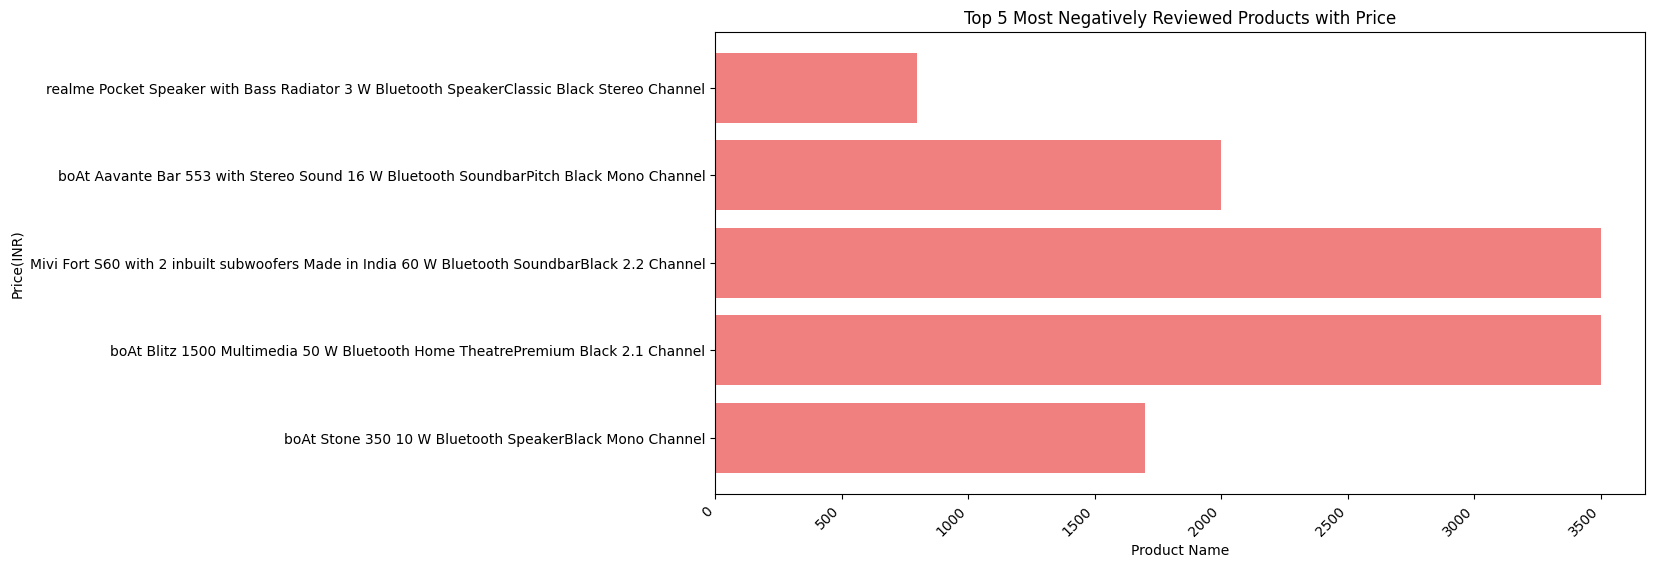

In [ ]:
plt.figure(figsize=(12, 6))

plt.barh(top_negative_pandas['Product_name'], top_negative_pandas['Price'], color='lightcoral')

# Labels and title
plt.xlabel('Product Name')
plt.ylabel('Price(INR)')
plt.title('Top 5 Most Negatively Reviewed Products with Price')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:

train_df, test_df = df_hashed.randomSplit([0.8, 0.2], seed=42)
majority_count = train_df.filter(train_df.sentiment_index == 0.0).count()
minority_count = train_df.filter(train_df.sentiment_index == 1.0).count()
oversample_ratio = majority_count / minority_count
minority_df = train_df.filter(train_df.sentiment_index == 1.0).sample(withReplacement=True, fraction=oversample_ratio)
majority_df = train_df.filter(train_df.sentiment_index == 0.0)
oversampled_df = majority_df.union(minority_df)





In [ ]:
oversampled_df.groupBy("sentiment_index").count().show()

+---------------+-----+
|sentiment_index|count|
+---------------+-----+
|            0.0| 4431|
|            1.0| 4453|
+---------------+-----+



In [ ]:

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="sentiment_index")
lr_model = lr.fit(oversampled_df)
lr_predictions = lr_model.transform(test_df)

In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.9092


In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='sentiment_index', maxIter=50)
gbt_model = gbt.fit(oversampled_df)
gbt_predictions = gbt_model.transform(test_df)


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment_index', predictionCol='prediction', metricName='accuracy')
gbt_accuracy = evaluator.evaluate(gbt_predictions)


In [ ]:
print(f"Gradient Boost Regression Accuracy: {gbt_accuracy:.4f}")

Gradient Boost Regression Accuracy: 0.9319
